Set up Colab requirements if in Colab, or autoreload if in jupyter

In [1]:
try: # test if running from colab
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    %cd /content
    !rm -rf gps-lane-changes
    !git clone https://github.com/tomdries/gps-lane-changes
    %cd gps-lane-changes
else:
    %load_ext autoreload 
    %autoreload 2
    

In [2]:
import pandas as pd
from pathlib import Path
import dataloaders
import matplotlib.pyplot as plt
import numpy as np
from analysis_helpers import *
from calculate_offset import angular_diff
import seaborn as sns

sns.set_style('white')


In [50]:
lca_dfs, trip_dfs, trip_names, road_dfs = dataloaders.load_data()

As direction calculation can get quite noisy at low speeds, we remove driving under 30 km/h. 

# Calculate offset and append to all dataframes
The output of the cell is already stored and loaded

In [32]:
# from calculate_offset import batch_append_offset
# trip_dfs_out = batch_append_offset(trip_dfs, trip_names, road_dfs, save_path=None)

# Create labeled time windows

Select trip and device

<img src="figures/sections.jpg" width=200 height=300 />

In [33]:
trip_dfs[0][1]

,t,date,lat_gps,lon_gps,alt,speed,speed3D,fix,precision,speed_haversine,...,offset,section,road type,lon,lat,strategy metric_road,chunk_match_ix_road,order_road,x,y
0,326.004339,2021-06-04 08:07:24.004000+00:00,51.990312,4.391410,-7.586758,26.702,96.336,3.0,130.0,26.338251,...,5.309097,A,straight,4.391534,51.990217,0.979971,1,170,86611.98382,445115.8338
1,327.050037,2021-06-04 08:07:25.050000+00:00,51.990070,4.391526,-7.615758,26.941,97.200,3.0,130.0,26.881497,...,4.669011,A,straight,4.391636,51.989984,0.979971,1,171,86618.63419,445089.8165
2,328.043659,2021-06-04 08:07:26.043000+00:00,51.989841,4.391639,-7.664758,26.677,96.156,3.0,130.0,26.455484,...,3.814296,A,straight,4.391737,51.989753,0.979971,1,172,86625.21900,445064.0227
3,329.027631,2021-06-04 08:07:27.027000+00:00,51.989616,4.391748,-7.527758,26.130,94.572,3.0,130.0,26.126373,...,3.256938,A,straight,4.391795,51.989621,0.979971,1,173,86629.00140,445049.2831
4,330.005156,2021-06-04 08:07:28.005000+00:00,51.989396,4.391849,-7.522758,25.673,92.268,3.0,130.0,26.293344,...,2.725377,A,straight,4.391939,51.989291,0.979971,1,175,86638.38883,445012.4350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109,3620.032928,2021-06-04 08:09:24.972000+00:00,51.989362,4.392275,0.758903,25.026,90.144,3.0,113.0,25.964728,...,7.052898,M,straight,4.392235,51.989211,0.901184,28,3640,86658.59737,445003.2565
2110,3621.007586,2021-06-04 08:09:25.947000+00:00,51.989578,4.392198,0.527903,24.714,88.920,3.0,112.0,24.349668,...,7.857663,M,straight,4.392101,51.989529,0.901184,28,3641,86649.87832,445038.7601
2111,3622.008586,2021-06-04 08:09:26.948000+00:00,51.989788,4.392123,0.393903,24.097,86.904,3.0,128.0,23.790935,...,8.830827,M,straight,4.392064,51.989618,0.901184,28,3642,86647.47267,445048.6962
2112,3623.035928,2021-06-04 08:09:27.975000+00:00,51.990004,4.392038,0.266903,23.510,84.744,3.0,112.0,24.587643,...,9.121007,M,straight,4.391930,51.989937,0.901184,28,3643,86638.75531,445084.3111


Calculate signals

In [34]:
filter_params = {'EWM_SPAN': 3,
                 'MEDFILT_SIZE': 4,
                 'PROJ_DIST_ROLLINGSUM': 3}

trip_dfs = calculate_signals_alltrips(trip_dfs, filter_params)

<IPython.core.display.Javascript object>


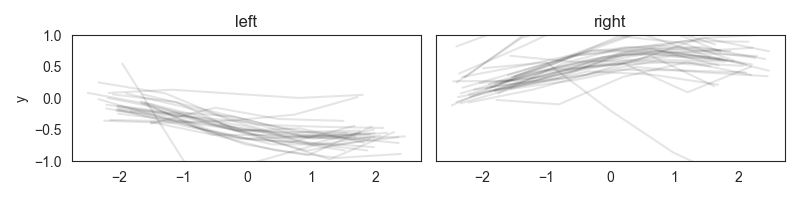

In [35]:
device_nr = 1
sections = ['A', 'M']

window_size=5
fragments = extract_lanechange_fragments_alltrips(trip_dfs, trip_names, lca_dfs, device_nr, sections, window_size)

params = {'ylims': (-1,1),
         'alpha': 0.1,
         'ylabel': 'y'}

plot_col = 'lat_vel_ewmfilt'
plot_fragments(fragments, plot_col, params)

# plt.savefig('figures/lanechanges.png', dpi=600, bbox_inches='tight')


In [58]:
for i_trip, lca_df in enumerate(lca_dfs):
    for direction in ['left', 'right']:
        min_t_diff = lca_df[lca_df.direction==direction].t_lc.diff().min()
        print("trip", i_trip, direction, "min_t_diff", min_t_diff)
       
    


trip 0 left min_t_diff 6.373000000000047
trip 0 right min_t_diff 4.0770000000002256
trip 1 left min_t_diff 5.579000000000065
trip 1 right min_t_diff 5.108999999999924
trip 2 left min_t_diff 5.956999999999994
trip 2 right min_t_diff 5.760999999999967


In [57]:
lca_dfs[0][lca_dfs[0].direction=='right']

,time start,time middle,time end,type,from lane,to lane,total lanes,direction,multiple lanes,t_lc,frame_number,section,road type
2,NaN,00.06.00.470,NaN,NaN,2,3,3.0,right,False,360.470,10803,A,straight
5,NaN,00.06.54.917,NaN,NaN,1,2,3.0,right,False,414.917,12435,A,straight
6,NaN,00.07.45.327,NaN,NaN,2,3,3.0,right,False,465.327,13946,A,straight
9,09.49.588,00.09.54.605,09.59.055,NaN,1,3,4.0,right,True,594.605,17820,A,straight
10,10.03.04,00.10.05.039,10.09.038,NaN,1,2,2.0,right,False,605.039,18133,A,straight
11,10.12.938,00.10.14.868,10.15.279,exit,2,3,3.0,right,False,614.868,18428,A,straight
14,31.02.813,00.31.04.259,31.06.887,NaN,1,2,2.0,right,False,1864.259,55872,E,straight
17,33.14.687,00.33.16.526,33.19.500,NaN,1,2,3.0,right,False,1996.526,59836,G,straight
18,33.31.978,00.33.33.806,33.35.940,NaN,2,3,3.0,right,False,2013.806,60354,G,straight
20,34.32.638,00.34.33.817,34.35.635,NaN,2,3,3.0,right,False,2073.817,62152,G,straight


In [49]:
60*34+40.269


2080.269

In [24]:
dev_nr = 1
trip_nr = 1
print(trip_names[trip_nr][dev_nr])
trip_df=trip_dfs[trip_nr][dev_nr]


02 GPS GoPro downsampled (last).csv


<IPython.core.display.Javascript object>


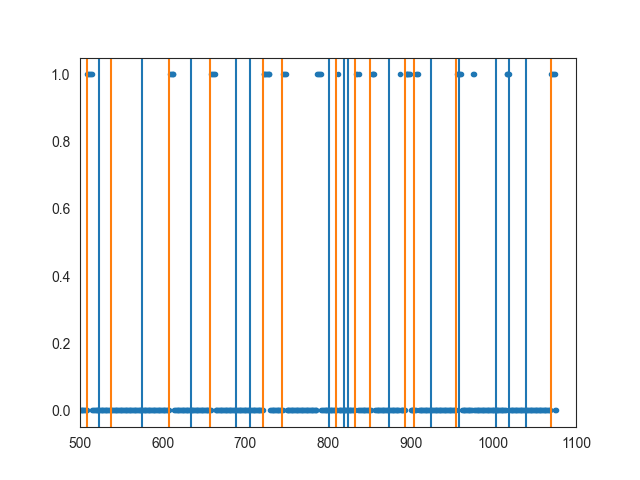

(500.0, 1100.0)

In [23]:
%matplotlib notebook
signal = 'lat_vel_ewmfilt'
threshold = 2

plt.plot(trip_df.t, trip_df[signal].rolling(5).sum()>threshold, linestyle='None', marker='.')
# plt.plot(trip_df.t, trip_df.lat_vel.rolling(5).sum(), color='green')
plot_lane_changes(lca_dfs[trip_nr])
# plt.plot(trip_df.t, trip_df.bearing_road.diff().rolling(3).median(), color='green')
plt.xlim(500,1100)

In [27]:
lca_dfs[trip_nr][20:30]

,time start,time middle,from lane,to lane,total lanes,type,direction,multiple lanes,t_lc,frame_number,section,road type
20,NaN,00.14.53.156,2.0,3.0,3.0,NaN,right,False,893.156,26768,C,straight
21,NaN,00.15.04.608,3.0,4.0,4.0,NaN,right,False,904.608,27111,C,straight
22,NaN,00.15.24.806,4.0,3.0,4.0,NaN,left,False,924.806,27716,C,straight
23,NaN,00.15.54.656,1.0,2.0,2.0,NaN,right,False,954.656,28611,C,straight
24,NaN,00.16.43.690,2.0,1.0,2.0,NaN,left,False,1003.690,30081,D,curve
25,NaN,00.16.58.404,3.0,2.0,5.0,NaN,left,False,1018.404,30522,E,straight
26,NaN,00.17.19.719,2.0,1.0,2.0,NaN,left,False,1039.719,31160,E,straight
27,NaN,00.17.49.510,1.0,2.0,2.0,NaN,right,False,1069.510,32053,E,straight
28,NaN,00.19.37.053,2.0,1.0,5.0,NaN,left,False,1177.053,35276,E,straight
29,NaN,00.20.07.445,2.0,3.0,2.0,NaN,right,False,1207.445,36187,E,straight
